In [1]:
# データセットの読み込み
from datasets import load_dataset
data_files = {}
for name in ["train", "val", "test"]:
    data_files[name] = f"data/qmsum/{name}.jsonl" 
data = load_dataset("json", data_files=data_files, cache_dir="data/preloaded")
data["train"][1]["query"]

/home/ace14385kw/anaconda3/envs/summarization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default-5818ee746fe49f1a


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 143.12it/s]


Dataset json downloaded and prepared to data/preloaded/json/default-5818ee746fe49f1a/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 242.26it/s]


'How Did Project Manager and User Interface introduce the prototype of the remote control?'

In [2]:
# モデルの読み込み
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_dir = "facebook/bart-large"
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

Token indices sequence length is longer than the specified maximum sequence length for this model (5747 > 1024). Running this sequence through the model will result in indexing errors


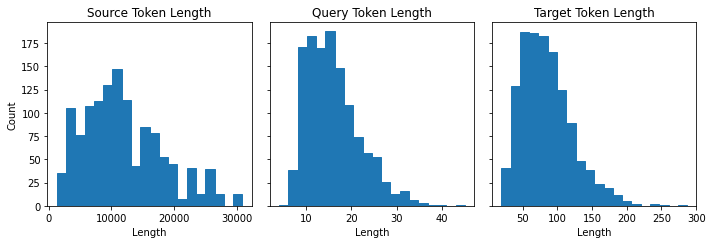

In [3]:
# データセットの確認
import matplotlib.pyplot as plt

s_len = [len(tokenizer.encode(s)) for s in data["train"]["source"]]
q_len = [len(tokenizer.encode(s)) for s in data["train"]["query"]]
t_len = [len(tokenizer.encode(s)) for s in data["train"]["target"]]

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True)
axes[0].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Source Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(q_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Query Token Length")
axes[1].set_xlabel("Length")
axes[2].hist(t_len, bins=20, color="C0", edgecolor="C0")
axes[2].set_title("Target Token Length")
axes[2].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [4]:
# データのtokenization
def tokenize(examples):
    inputs = [f"<s>{query}</s>{source}</s>" for query, source in zip(examples["query"], examples["source"])]
    model_inputs = tokenizer(
        inputs,
        max_length=tokenizer.model_max_length,
        add_special_tokens=False,
        truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target"], 
            max_length=tokenizer.model_max_length,
            add_special_tokens=False,
            truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_qmsum = data.map(tokenize, batched=True)

Parameter 'function'=<function tokenize at 0x7fbac77d7a70> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [5]:
# モデルの訓練・ファインチューニング
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="bart-large-qmsum",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    fp16=True,
    push_to_hub=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_qmsum["train"],
    eval_dataset=tokenized_qmsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

ValueError: Mixed precision training with AMP or APEX (`--fp16`) and FP16 evaluation can only be used on CUDA devices.

In [25]:
from datasets import load_metric
rouge_metric = load_metric("rouge")
